In [392]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [393]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [394]:
np.random.seed(0)

# 2.a.1. Draw Exercise Boundary for American Put Option

In [395]:
# basic 
T = 1
S0 = 10
mu = 0.05
sigma = 0.2
r = 0.02
N = 5000
# N = 100
K = 10


## Using B as a numeraire 

In [396]:
def asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K):
    timeStep = T / N
    u = np.exp(r * timeStep + sigma * np.sqrt(timeStep))  # one-step asset increase under P 
    d = np.exp(r * timeStep - sigma * np.sqrt(timeStep))  # one-step asset increase under P
    # risk neutral probability
    Qu = 0.5 * (1 - 0.5 * sigma * np.sqrt(timeStep))  # see answers in Q1
    Qd = 1 - Qu
    # asset tree
    asset_tree = np.full((N + 1, N + 1), np.nan)
    # initiate with current price
    asset_tree[0, 0] = S0
    for i in range(1, N + 1):
        # we only use the top diagonal of the tree
        asset_tree[0:i, i] = asset_tree[0:i, i - 1] * u
        asset_tree[i, i] = asset_tree[i - 1, i - 1] * d
    # Calculate the option value
    Q_option_tree = np.full((N + 1, N + 1), np.nan)
    Q_option_tree[:, -1] = np.maximum(K - asset_tree[:, -1], 0)
    for i in range(N - 1, -1, -1):
        previous_numeraire = np.exp(r * (i + 1) / N)
        current_numeraire = np.exp(r * i / N)

        Q_option_tree[0:i + 1, i] = (Qu * Q_option_tree[0:i + 1, i + 1] / previous_numeraire + Qd * Q_option_tree[
                                                                                                    1:i + 2,
                                                                                                    i + 1] / previous_numeraire) * current_numeraire
        # because this is an american option, we consider the early exercise possibility
        Q_option_tree[0:i + 1, i] = np.maximum(K - asset_tree[0:i + 1, i], Q_option_tree[0:i + 1, i])
    return asset_tree, Q_option_tree

## Demonstrate that by using A as numeraire, the option price is the same

In [397]:
def asset_n_option_tree_S_numeraire(T, S0, sigma, r, N, K):
    timeStep = T / N
    u = np.exp(r * timeStep + sigma * np.sqrt(timeStep))  # one-step asset increase under P 
    d = np.exp(r * timeStep - sigma * np.sqrt(timeStep))  # one-step asset increase under P
    # risk neutral probability
    Qsu = 0.5 * (1 + 0.5 * sigma * np.sqrt(timeStep))  # see answers in Q1
    Qsd = 1 - Qsu
    # asset tree is the same because it is under P, not Q
    asset_tree = np.full((N + 1, N + 1), np.nan)
    # initiate with current price
    asset_tree[0, 0] = S0
    for i in range(1, N + 1):
        # we only use the top diagonal of the tree
        asset_tree[0:i, i] = asset_tree[0:i, i - 1] * u
        asset_tree[i, i] = asset_tree[i - 1, i - 1] * d
    # calculate the option value
    Qs_option_tree = np.full((N + 1, N + 1), np.nan)
    Qs_option_tree[:, -1] = np.maximum(K - asset_tree[:, -1], 0)
    for i in range(N - 1, -1, -1):
        previous_u_numeraire = asset_tree[0:i + 1, i + 1]
        previous_d_numeraire = asset_tree[1:i + 2, i + 1]
        current_numeraire = asset_tree[0:i + 1, i]
        # previous_B = np.exp(r * (i + 1) / N)
        Qs_option_tree[0:i + 1, i] = (Qsu * Qs_option_tree[0:i + 1,
                                            i + 1] / previous_u_numeraire + Qsd * Qs_option_tree[
                                                                                  1:i + 2,
                                                                                  i + 1] / previous_d_numeraire) * current_numeraire
        # consider american option early exercise
        Qs_option_tree[0:i + 1, i] = np.maximum(K - asset_tree[0:i + 1, i], Qs_option_tree[0:i + 1, i])

    return asset_tree, Qs_option_tree


In [398]:
asset_tree, Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, sigma, r, N, K)
asset_tree_S, Qs_option_tree = asset_n_option_tree_S_numeraire(T, S0, sigma, r, N, K)

plot note: figure out a way of demonstrating this. maybe plot the first few prices?

In [400]:
Q_option_tree[:10, :10]

array([[0.71112048, 0.69878289, 0.68657669, 0.67450213, 0.66255939,
        0.65074866, 0.63907007, 0.62752373, 0.61610973, 0.60482811],
       [       nan, 0.72342891, 0.71096019, 0.69862264, 0.68641652,
        0.67434206, 0.66239946, 0.6505889 , 0.63891051, 0.62736441],
       [       nan,        nan, 0.7358682 , 0.72326857, 0.71079986,
        0.69846236, 0.68625631, 0.67418196, 0.6622395 , 0.65042911],
       [       nan,        nan,        nan, 0.74843811, 0.73570785,
        0.7231082 , 0.71063951, 0.69830204, 0.68609607, 0.67402183],
       [       nan,        nan,        nan,        nan, 0.76113841,
        0.74827778, 0.73554746, 0.7229478 , 0.71047911, 0.6981417 ],
       [       nan,        nan,        nan,        nan,        nan,
        0.77396879, 0.76097812, 0.74811741, 0.73538704, 0.72278736],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.78692895, 0.77380858, 0.7608178 , 0.74795701],
       [       nan,        nan,        na

In [401]:
Qs_option_tree[:10, :10]

array([[0.71112039, 0.69878279, 0.6865766 , 0.67450203, 0.6625593 ,
        0.65074857, 0.63906998, 0.62752364, 0.61610964, 0.60482802],
       [       nan, 0.72342882, 0.71096009, 0.69862254, 0.68641642,
        0.67434197, 0.66239937, 0.65058881, 0.63891042, 0.62736431],
       [       nan,        nan, 0.7358681 , 0.72326848, 0.71079977,
        0.69846226, 0.68625622, 0.67418187, 0.66223941, 0.65042902],
       [       nan,        nan,        nan, 0.74843802, 0.73570775,
        0.72310811, 0.71063941, 0.69830195, 0.68609598, 0.67402174],
       [       nan,        nan,        nan,        nan, 0.76113831,
        0.74827768, 0.73554736, 0.7229477 , 0.71047902, 0.6981416 ],
       [       nan,        nan,        nan,        nan,        nan,
        0.77396869, 0.76097802, 0.74811731, 0.73538694, 0.72278727],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.78692885, 0.77380848, 0.7608177 , 0.74795691],
       [       nan,        nan,        na

In [458]:
def execution_boundary_calculation(K, asset_tree, Q_option_tree):
    def np_groupby(data, key):
        # helper function for numpy to do groupby 
        unique_keys = np.unique(key)
        grouped_data = {unique_key: [] for unique_key in unique_keys}
        for i in range(len(data)):
            grouped_data[key[i]].append(data[i])
        return grouped_data

    grouped_timestamp = np_groupby(*np.where((K - asset_tree - Q_option_tree) ==0))
    grouped_timestamp = np.vstack([[min(item) for item in grouped_timestamp.values()], list(grouped_timestamp.keys())])
    execution_boundary = asset_tree[grouped_timestamp[0], grouped_timestamp[1]]
    return grouped_timestamp, execution_boundary

In [451]:
grouped_timestamp, execution_boundary = execution_boundary_calculation(K, asset_tree, Q_option_tree)

Note for plot: give title, change this to black, add legend, add axis name

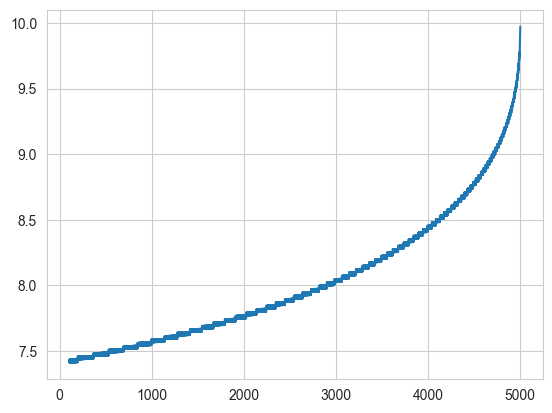

In [452]:
plt.plot(grouped_timestamp[1], execution_boundary)

# 2.a.2. Path Simulation

In [307]:
def sample_path(S0, T, N, r, mu, sigma):
    timeStep = T / N
    prob_epsilon_up = 0.5 * (1 + ((mu - r) - 0.5 * sigma ** 2) / sigma * np.sqrt(timeStep))
    Ntrials = 10_000
    total_path = np.empty((Ntrials, N + 1))
    total_path[:, 0] = S0
    for i in range(N):
        U = np.random.rand(Ntrials)
        epsilon = 1 * (U < prob_epsilon_up) + (-1) * (U >= prob_epsilon_up)  # realization of epsilon
        total_path[:, i + 1] = total_path[:, i] * np.exp(r * timeStep + sigma * np.sqrt(timeStep) * epsilon)
    return total_path

In [308]:
total_path = sample_path(S0, T, N, r, mu, sigma)

note for plot:
add title, axis name, legend name more details

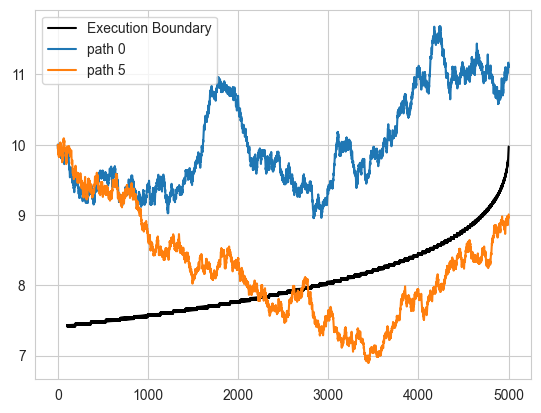

In [309]:
plt.plot(grouped_timestamp[1], execution_boundary, label='Execution Boundary', color='black')
for i in range(10):
    if i == 5 or i == 0:
        plt.plot(total_path[i, :].T, label=f'path {i}')
plt.legend()


In [310]:
execution_boundary[0]

7.433674197374958

# 2.a.3. Option Hedge Strategy

In [311]:
asset_tree.shape

(5001, 5001)

In [416]:
def generate_hedge_strategy(asset_tree, Q_option_tree, path, N, r):
    alpha = []
    beta = []
    for idx, price in enumerate(path[:-1]):
        # time = idx+1
        time = idx
        location = np.where(np.abs(price - asset_tree[:, time]) < 0.0001)[0][
            0]  # the tolerance is because memory accuracy
        option_up = Q_option_tree[location, time + 1]
        option_down = Q_option_tree[location + 1, time + 1]
        asset_price_up = asset_tree[location, time + 1]
        asset_price_down = asset_tree[location + 1, time + 1]
        alpha_i = (option_up - option_down) / (asset_price_up - asset_price_down)
        B = np.exp(r * ((time + 1) / N))
        beta_i = (option_up - alpha_i * asset_price_up) / B
        alpha.append(alpha_i)
        beta.append(beta_i)
    return alpha, beta

In [417]:
alpha, beta = generate_hedge_strategy(asset_tree, Q_option_tree, total_path[5], N, r)

In [418]:
option_price_path = []
for time, price in enumerate(total_path[5, :]):
    location = np.where(np.abs(price - asset_tree[:, time]) < 0.0001)[0]  # the tolerance is because memory accuracy
    option_price_path.append(Q_option_tree[location, time][0])

Note for plot:
because we plot both prices and positions, the y axis should be different on the same plot. so there should be two y axis left and right

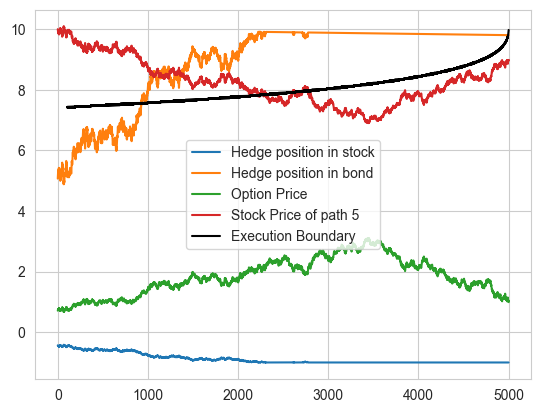

In [419]:
plt.plot(alpha, label='Hedge position in stock')
plt.plot(beta, label='Hedge position in bond')
plt.plot(option_price_path, label='Option Price')
plt.plot(total_path[5, :-1], label='Stock Price of path 5')
plt.plot(grouped_timestamp[1], execution_boundary, label='Execution Boundary', color='black')
plt.legend()
plt.show()

note for plot:
similarly plot alpha beta together using 2 y axis

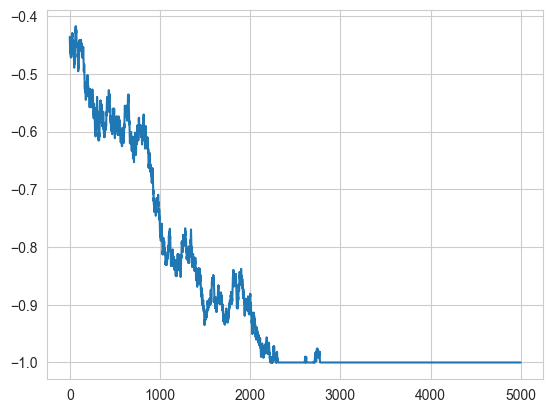

In [420]:
plt.plot(alpha)

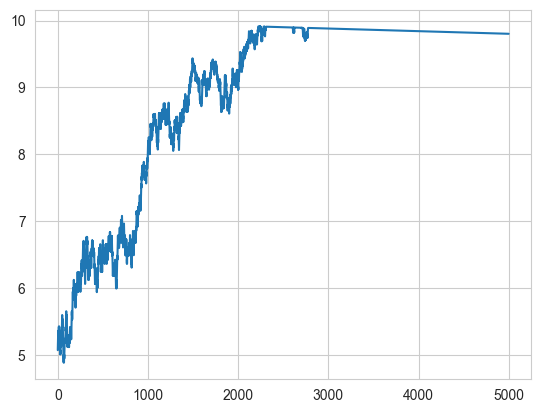

In [421]:
plt.plot(beta)

In [422]:
hedge_portfolio = np.array(alpha) * total_path[5, :-1] + np.array(beta) * np.exp(r * np.arange(0, 1, 1 / N))

note for plot: plot hedge portfolio and option price together, add a small deviation for better visualization, and add legend to explain that the two lines are actually the same

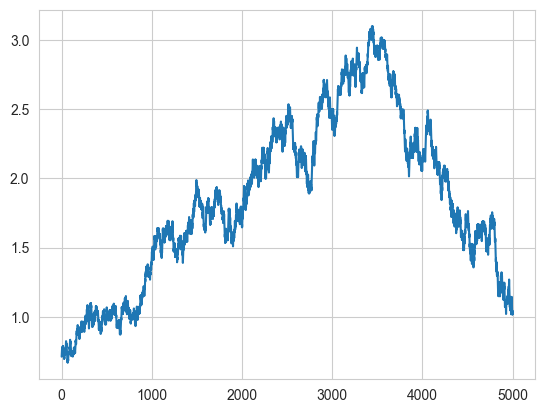

In [423]:
plt.plot(hedge_portfolio)

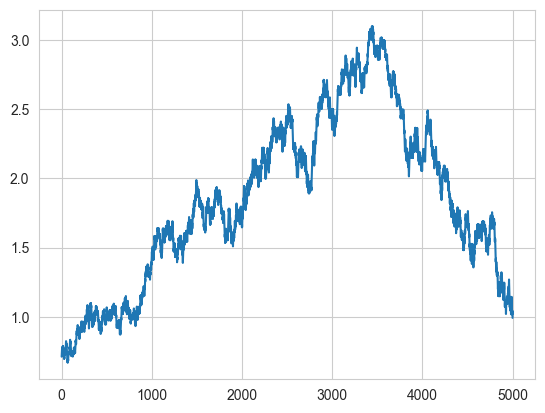

In [424]:
plt.plot(option_price_path)

# 2.b.1 P&L Distribution: 
Three situations:
1. if we did not hit the exercise boundary and execute the option, there is nothing to gain, pure losses at the exact value of the option at t=0. 
2. (rare) if we hit the exercise at the very end (i.e. t=5000), its still expiring worthless
3. if we did execute, our P&L is the K-asset discounted back to t=0 then minus the option price
probability of exercise needs to account for the probability of stock price never reached the execution boundary

Note that if the executed profit discount to t=0 is less than the option price, you lose money even if you execute

In [321]:
sample_path_20vol = sample_path(S0, T, N, r, mu, sigma)

In [322]:
sample_path_20vol.shape

(10000, 5001)

In [426]:
def execution_details(sample_path, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N):
    # call execution boundary calculation before this function
    exercise_dic = {}
    padding_space = grouped_timestamp[1][0]
    for idx, path in enumerate(sample_path):
        execution_time = np.where(np.abs(path[padding_space:] - execution_boundary) < 0.0001)[0]
        if len(execution_time) == 0:
            # no execution
            continue
        else:
            execution_time = execution_time[0]
            if execution_time + padding_space == 5000:
                # exercise at the very end, expiring worthless
                continue
            # Execute before expiry. We calculate the P&L and store it in a dictionary with key=idx, value=[execution_time+padding_space, P&L]
            profit = (K - execution_boundary[execution_time]) * np.exp(-r * (execution_time + padding_space) / N) - \
                     Q_option_tree[0, 0]
            exercise_dic[idx] = [execution_time + padding_space, profit]
    return pd.DataFrame(exercise_dic).T.reset_index().rename(
        columns={'index': 'path', 0: 'execution_time', 1: 'profit'})

In [427]:
exercise_df = execution_details(sample_path_20vol, grouped_timestamp, execution_boundary, Q_option_tree, K, r, N)

Note for plot: plot the histogram of execution time and profit with title, axis name, legend name, value for each bar. put the value of the mean of profit on the plot

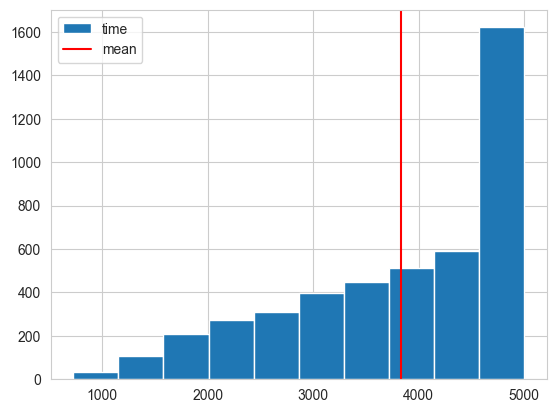

In [428]:
exercise_df['execution_time'].hist(label='time')
plt.axvline(exercise_df['execution_time'].mean(), color='red', label='mean')
plt.legend()

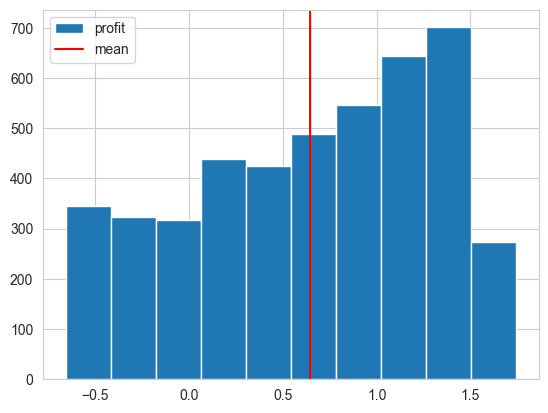

In [429]:
exercise_df['profit'].hist(label='profit')
plt.axvline(exercise_df['profit'].mean(), color='red', label='mean')
plt.legend()

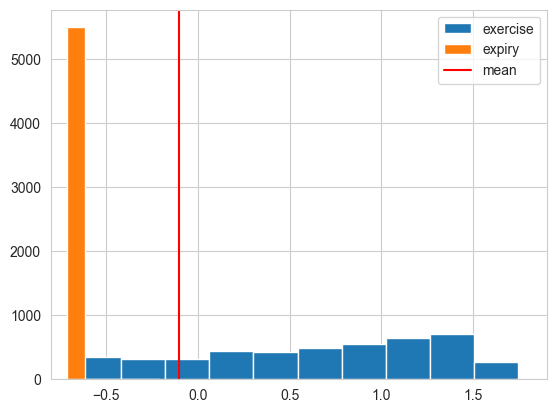

In [430]:
plt.hist(exercise_df['profit'].values, label='exercise')
plt.hist([-Q_option_tree[0, 0]] * (10_000 - len(exercise_df)), label='expiry')
all_path_pnl = np.hstack([exercise_df['profit'].values, [-Q_option_tree[0, 0]] * (10_000 - len(exercise_df))])
plt.axvline(all_path_pnl.mean(), color='red', label='mean')
plt.xlim(-0.8, 1.9)
plt.legend()
plt.show()

# 2.b.3. If purchased the option with vol 20%, you execute with 20% volatility execution boundary, but the realized volatility is 30%, what is the P&L distribution?
this means the option tree is the same, exercise boundary is the same, but the path is different.
option value positively correlate with volatility, so if we buy the option with 20% vol, we are paying a lower price than the option with 30% vol.

In [466]:
def market_mis_pricing_execution_expected_profit(option_implied_vol,realized_vol, S0, T, N, r, mu, K):
    # this may take a while
    assert option_implied_vol != realized_vol
    sample_path_realized_vol = sample_path(S0, T, N, r, mu, realized_vol)
    sample_path_option_implied_vol = sample_path(S0, T, N, r, mu, option_implied_vol)
    
    correct_asset_tree,correct_Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, option_implied_vol, r, N, K)
    mis_pricing_asset_tree,mis_pricing_Q_option_tree = asset_n_option_tree_B_numeraire(T, S0, realized_vol, r, N, K)
    
    correct_time_stamp,correct_price_exercise_boundary = execution_boundary_calculation(K, correct_asset_tree, correct_Q_option_tree)
    mis_pricing_time_stamp,mis_pricing_price_exercise_boundary = execution_boundary_calculation(K, mis_pricing_asset_tree, mis_pricing_Q_option_tree)
    
    fair_vol_execution = execution_details(sample_path_option_implied_vol, correct_time_stamp, correct_price_exercise_boundary, correct_Q_option_tree, K, r, N)
    passive_vol_execution = execution_details(sample_path_realized_vol, correct_time_stamp, correct_price_exercise_boundary, correct_Q_option_tree, K, r, N)
    active_vol_execution = execution_details(sample_path_realized_vol, mis_pricing_time_stamp, mis_pricing_price_exercise_boundary, correct_Q_option_tree, K, r, N)
    
    return fair_vol_execution, passive_vol_execution, active_vol_execution

In [483]:
def expected_pnl_include_no_execution(profit):
    # this is the expected pnl if we include the no execution case
    return profit.mean() * (len(profit) / 10_000) + (-Q_option_tree[0, 0]) * (1 - len(profit) / 10_000)# use Q_option_tree[0,0] as the option price at vol 20
    

Plot note: i've done most of the plot, add value for the mean value vertical line, add title, axis name, adjust legend position, bin size, we should be fine
include a discussion about the "fair vol", and that it is unfair to compare numerically the expected profit of the fair vol and the other two because of the asset path difference

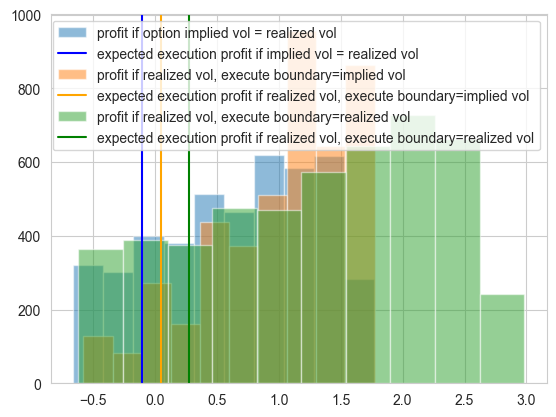

In [484]:
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(0.2,0.3, S0, T, N, r, mu, K)
fair_vol_execution['profit'].hist(label='profit if option implied vol = realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']), color='blue', label='expected execution profit if implied vol = realized vol, Include expiry')
passive_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=implied vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange', label='expected execution profit if realized vol, execute boundary=implied vol, Include expiry')
active_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green', label='expected execution profit if realized vol, execute boundary=realized vol, Include expiry')
plt.legend()
plt.show()

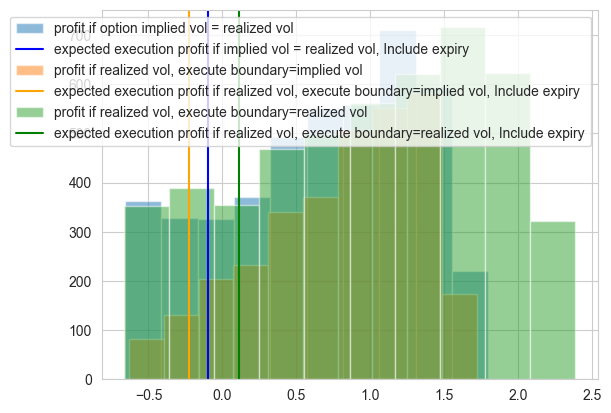

In [485]:
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(0.2,0.25, S0, T, N, r, mu, K)
fair_vol_execution['profit'].hist(label='profit if option implied vol = realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']), color='blue', label='expected execution profit if implied vol = realized vol, Include expiry')
passive_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=implied vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange', label='expected execution profit if realized vol, execute boundary=implied vol, Include expiry')
active_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green', label='expected execution profit if realized vol, execute boundary=realized vol, Include expiry')
plt.legend()
plt.show()

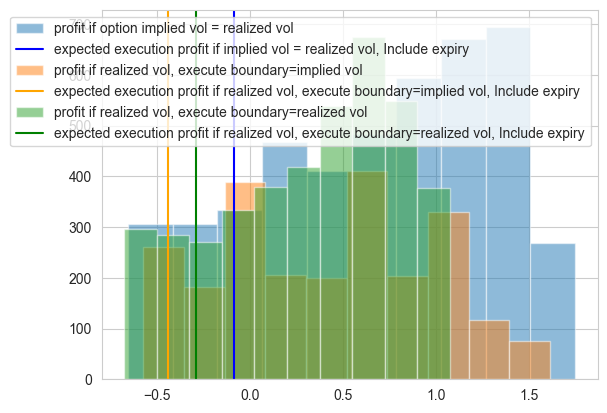

In [486]:
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(0.2,0.15, S0, T, N, r, mu, K)
fair_vol_execution['profit'].hist(label='profit if option implied vol = realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']), color='blue', label='expected execution profit if implied vol = realized vol, Include expiry')
passive_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=implied vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange', label='expected execution profit if realized vol, execute boundary=implied vol, Include expiry')
active_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green', label='expected execution profit if realized vol, execute boundary=realized vol, Include expiry')
plt.legend()
plt.show()

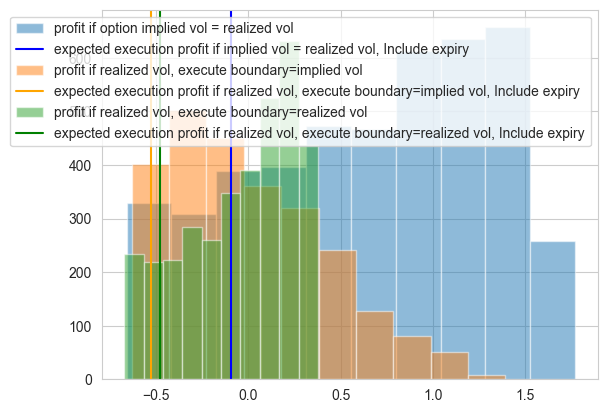

In [487]:
fair_vol_execution, passive_vol_execution, active_vol_execution = market_mis_pricing_execution_expected_profit(0.2,0.1, S0, T, N, r, mu, K)
fair_vol_execution['profit'].hist(label='profit if option implied vol = realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(fair_vol_execution['profit']), color='blue', label='expected execution profit if implied vol = realized vol, Include expiry')
passive_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=implied vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(passive_vol_execution['profit']), color='orange', label='expected execution profit if realized vol, execute boundary=implied vol, Include expiry')
active_vol_execution['profit'].hist(label='profit if realized vol, execute boundary=realized vol',alpha = 0.5)
plt.axvline(expected_pnl_include_no_execution(active_vol_execution['profit']), color='green', label='expected execution profit if realized vol, execute boundary=realized vol, Include expiry')
plt.legend()
plt.show()